In [1]:
from my_packages import *
from appgeopy import *
from demo_nonstationary import *

In [2]:
"""Demonstrate PCA imputation on stationary and non-stationary time series."""
# Parameters
n = 500  # Length of time series
embedding_dim = 10  # Dimension for time-delay embedding
missing_ratio = 0.2  # Fraction of missing values
random_seed = 42  # For reproducibility

In [3]:
print("\n=== Generating Time Series Data ===")
# Generate non-stationary time series
nonstationary_series = generate_nonstationary_series(n=n)
print(f"Generated non-stationary time series with length: {len(nonstationary_series)}")

# Generate stationary time series
stationary_series = generate_stationary_series(n=n)
print(f"Generated stationary time series with length: {len(stationary_series)}")


=== Generating Time Series Data ===
Generated non-stationary time series with length: 500
Generated stationary time series with length: 500


In [4]:
# Introduce missing values
nonstationary_missing, nonstationary_mask = introduce_missing_values(
    nonstationary_series, missing_ratio, random_seed)
stationary_missing, stationary_mask = introduce_missing_values(
    stationary_series, missing_ratio, random_seed)

print(f"Introduced {np.sum(nonstationary_mask)} missing values in each series")

Introduced 114 missing values in each series


In [5]:
# Check stationarity
print("\n=== Stationarity Tests ===")
adf_nonstationary = adfuller(nonstationary_series)
print(f"Non-stationary series ADF p-value: {adf_nonstationary[1]:.6f}")

adf_stationary = adfuller(stationary_series)
print(f"Stationary series ADF p-value: {adf_stationary[1]:.6f}")


=== Stationarity Tests ===
Non-stationary series ADF p-value: 0.524300
Stationary series ADF p-value: 0.000000


In [6]:
# Approach 1: Direct PCA imputation on both series
print("Applying PCA imputation directly to both series...")

# Create embeddings
nonstationary_embedded = create_embedding(nonstationary_missing, embedding_dim)
stationary_embedded = create_embedding(stationary_missing, embedding_dim)

# Apply PCA imputation
nonstationary_imputed_embedded = impute(nonstationary_embedded, n_components=3)
stationary_imputed_embedded = impute(stationary_embedded, n_components=3)

# Reconstruct time series
nonstationary_imputed_direct = reconstruct_original_series(
    nonstationary_imputed_embedded, len(nonstationary_series))
stationary_imputed_direct = reconstruct_original_series(
    stationary_imputed_embedded, len(stationary_series))

# Evaluate imputation accuracy
print("\n=== Imputation Accuracy (Direct Application) ===")
nonstationary_metrics_direct = evaluate_imputation(
    nonstationary_series, nonstationary_imputed_direct, nonstationary_mask)
stationary_metrics_direct = evaluate_imputation(
    stationary_series, stationary_imputed_direct, stationary_mask)

print("Non-stationary series (direct imputation):")
for metric, value in nonstationary_metrics_direct.items():
    print(f"  {metric}: {value:.4f}")

print("\nStationary series (direct imputation):")
for metric, value in stationary_metrics_direct.items():
    print(f"  {metric}: {value:.4f}")

Applying PCA imputation directly to both series...

=== Imputation Accuracy (Direct Application) ===
Non-stationary series (direct imputation):
  MAE: 1.5078
  RMSE: 2.1147
  R²: 0.9315

Stationary series (direct imputation):
  MAE: 0.8160
  RMSE: 1.0332
  R²: 0.3742


In [7]:
# Approach 2: Transform non-stationary series to achieve stationarity
# Then apply PCA imputation, and finally inverse transform

# Transform to stationary
transformed_series, inverse_transform = transform_to_stationary(nonstationary_missing)

# Create embedding of transformed series
transformed_embedded = create_embedding(transformed_series, embedding_dim)

# Apply PCA imputation
transformed_imputed_embedded = impute(transformed_embedded, n_components=3)

# Reconstruct transformed time series
transformed_imputed = reconstruct_original_series(
    transformed_imputed_embedded, len(transformed_series))

# Apply inverse transformation
nonstationary_imputed_with_preprocessing = inverse_transform(transformed_imputed)

# Evaluate imputation accuracy
print("\n=== Imputation Accuracy (With Preprocessing) ===")
nonstationary_metrics_preprocessed = evaluate_imputation(
    nonstationary_series, nonstationary_imputed_with_preprocessing, nonstationary_mask)

print("Non-stationary series (with preprocessing):")
for metric, value in nonstationary_metrics_preprocessed.items():
    print(f"  {metric}: {value:.4f}")


Series is non-stationary (ADF p-value: 0.6185)
Applying first-order differencing...
Transformed series stationarity: ADF p-value = 0.0000

=== Imputation Accuracy (With Preprocessing) ===
Non-stationary series (with preprocessing):
  MAE: 12.3928
  RMSE: 13.8835
  R²: -1.9536


In [8]:
# Summary of results
print("\n=== Summary of Imputation Results ===")

metrics = ['MAE', 'RMSE', 'R²']
methods = [
    'Non-stationary (direct)',
    'Non-stationary (with preprocessing)',
    'Stationary (direct)'
]

results = [
    [nonstationary_metrics_direct[m] for m in metrics],
    [nonstationary_metrics_preprocessed[m] for m in metrics],
    [stationary_metrics_direct[m] for m in metrics]
]

results_df = pd.DataFrame(results, index=methods, columns=metrics)
print(results_df)


=== Summary of Imputation Results ===
                                           MAE       RMSE        R²
Non-stationary (direct)               1.507836   2.114651  0.931478
Non-stationary (with preprocessing)  12.392824  13.883489 -1.953606
Stationary (direct)                   0.816006   1.033236  0.374163


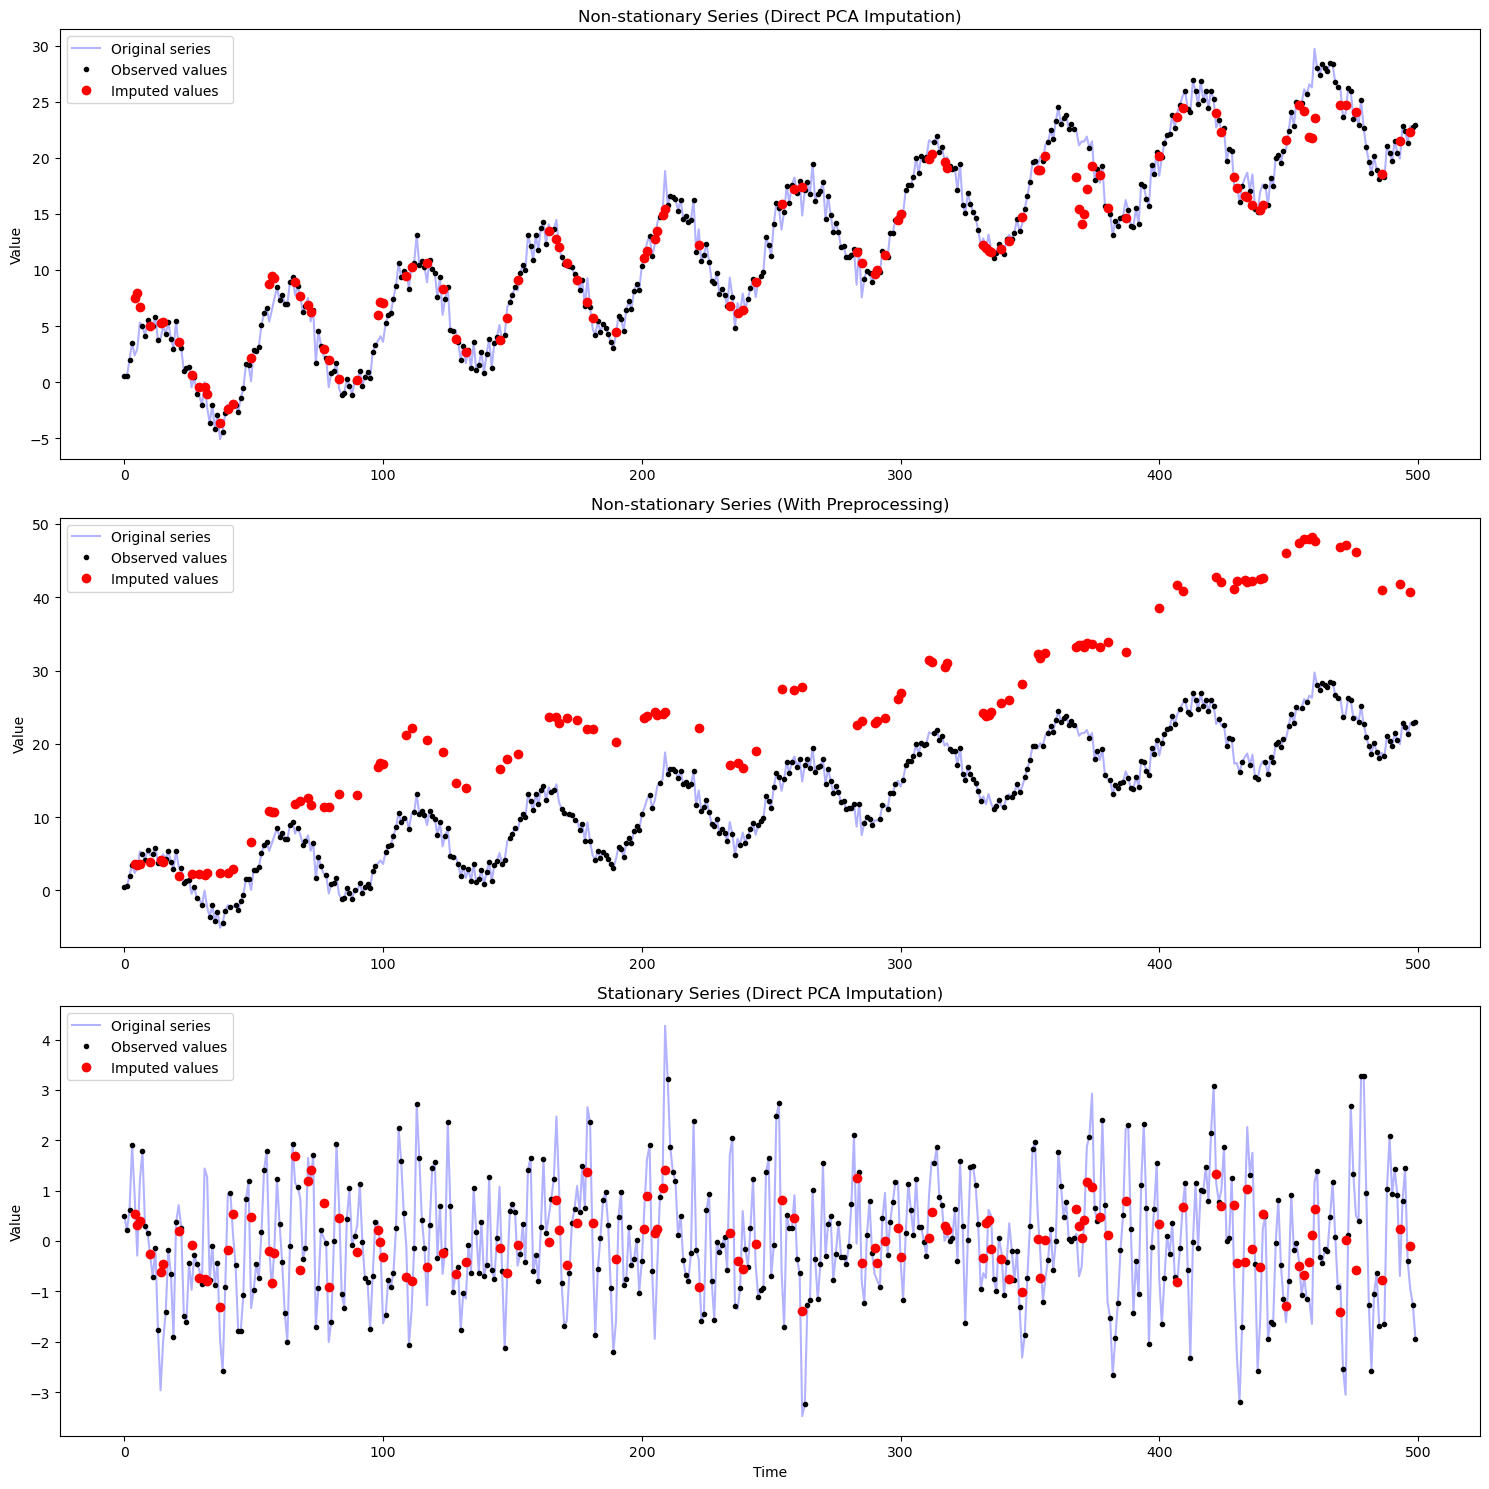

In [9]:
# Assuming plot_time_series function is defined elsewhere

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

# Non-stationary Series (Direct PCA Imputation)
plot_time_series(
    nonstationary_series, nonstationary_missing, nonstationary_imputed_direct,
    'Non-stationary Series (Direct PCA Imputation)', ax=axes[0]
)
axes[0].set_ylabel('Value')

# Non-stationary Series (With Preprocessing)
plot_time_series(
    nonstationary_series, nonstationary_missing, nonstationary_imputed_with_preprocessing,
    'Non-stationary Series (With Preprocessing)', ax=axes[1]
)
axes[1].set_ylabel('Value')

# Stationary Series (Direct PCA Imputation)
plot_time_series(
    stationary_series, stationary_missing, stationary_imputed_direct,
    'Stationary Series (Direct PCA Imputation)', ax=axes[2]
)
axes[2].set_ylabel('Value')
axes[2].set_xlabel('Time')

plt.tight_layout()
# plt.savefig('pca_imputation_comparison.png')
plt.show()
